In [1]:
import os
import yaml
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
from rtree import index
import glob
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transformsnormalized_price

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
## Implement the model

# GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name='efficientnet_b3'):
        super(EfficientNetRegressor, self).__init__()
        
        self.backbone = timm.create_model(model_name, 
                                         pretrained=True,
                                         num_classes=0,
                                         global_pool='avg')
        
        # Single output neuron for regression
        self.regressor = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features)


# Put model on GPU
model = EfficientNetRegressor(model_name='efficientnet_b3')
model = model.to(device)

print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"Model is on: {next(model.parameters()).device}")

Using device: cpu


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

GPU available: False
GPU name: None
Model is on: cpu


In [ ]:
## Load the trained model
model = EfficientNetRegressor()
model.load_state_dict(torch.load("/kaggle/input/best-regression-model-berlin/best_regression_model_berlin.pth", map_location="cpu"))
model.eval()

# pick the last convolutional layer of EfficientNet_B3
# (for EfficientNet, good choice is the last "features" block)
target_layer = model.backbone.conv_head 

In [ ]:
## Forward & backward hooks
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations["value"] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0].detach()

In [5]:
# load Berlin images
images_Gropiusstadt = []
images_Marzahn = []
images_Mitte = []
images_Tiergarten = []

image_folder_Gropiusstadt = "/kaggle/input/cam-berlin-vortrag/Berlin_vortrag/Gropius_stadt"
image_folder_Marzahn = "/kaggle/input/cam-berlin-vortrag/Berlin_vortrag/Marzahn"
image_folder_Mitte = "/kaggle/input/cam-berlin-vortrag/Berlin_vortrag/Mitte"
image_folder_Tiergarten = "/kaggle/input/cam-berlin-vortrag/Berlin_vortrag/Tiergarten"

for filename in os.listdir(image_folder_Gropiusstadt):
    img_path = os.path.join(image_folder_Gropiusstadt, filename)
    img = Image.open(img_path).convert("RGB")
    images_Gropiusstadt.append(img)

for filename in os.listdir(image_folder_Marzahn):
    img_path = os.path.join(image_folder_Marzahn, filename)
    img = Image.open(img_path).convert("RGB")
    images_Marzahn.append(img)

for filename in os.listdir(image_folder_Mitte):
    img_path = os.path.join(image_folder_Mitte, filename)
    img = Image.open(img_path).convert("RGB")
    images_Mitte.append(img)

for filename in os.listdir(image_folder_Tiergarten):
    img_path = os.path.join(image_folder_Tiergarten, filename)
    img = Image.open(img_path).convert("RGB")
    images_Tiergarten.append(img)

In [6]:
def image_preprocess(imgs, X):
    # preprocesses images
    # imgs: contains the original images
    # X: contains the preprocessed images
    preprocess = transforms.Compose([
        transforms.Resize((300, 300)),   # EfficientNet_B3 expects 300x300
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    for ii in imgs:
        x = preprocess(ii).unsqueeze(0)  # (1,3,300,300)
        X.append(x)

X_Gropiusstadt = []
X_Marzahn = []
X_Mitte = []
X_Tiergarten = []

image_preprocess(images_Gropiusstadt, X_Gropiusstadt)
image_preprocess(images_Marzahn, X_Marzahn)
image_preprocess(images_Mitte, X_Mitte)
image_preprocess(images_Tiergarten, X_Tiergarten)

In [ ]:
## Forward + Backward
def CAM(x):
    out = model(x)              # regression output
    scalar = out.squeeze()      # ensure scalar
    model.zero_grad()
    scalar.backward()

    # compute CAM
    acts = activations["value"]   # (1,C,h,w)
    grads = gradients["value"]    # (1,C,h,w)

    weights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)
    cam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)
    cam = torch.relu(cam)
    cam = F.interpolate(cam, size=(640,640), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # normalize [0,1]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [ ]:
## Plot results
def Plot(cam, img, name, number):
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM heatmap")
    plt.imshow(cam, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(img)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.axis("off")

    # plt.savefig('/kaggle/working/Grad-CAM_'+img_path)
    plt.savefig('/kaggle/working/GradCAM_'+name+f'_{number}.jpg')

    plt.show()

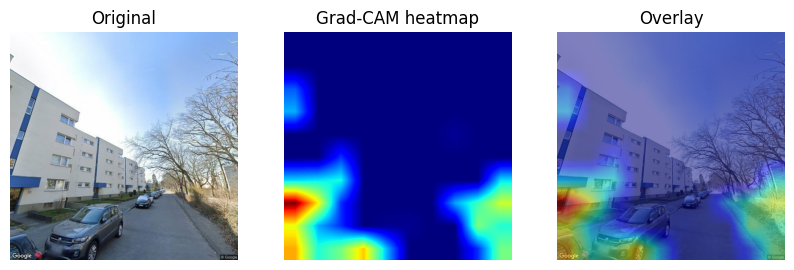

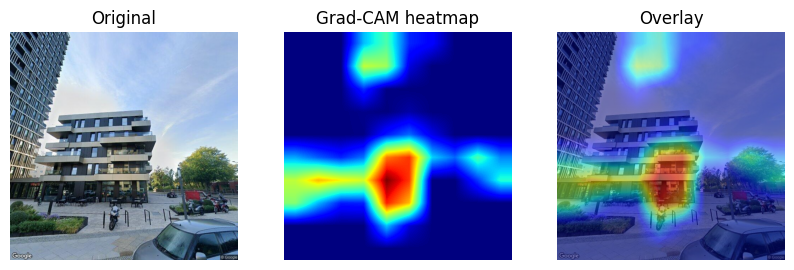

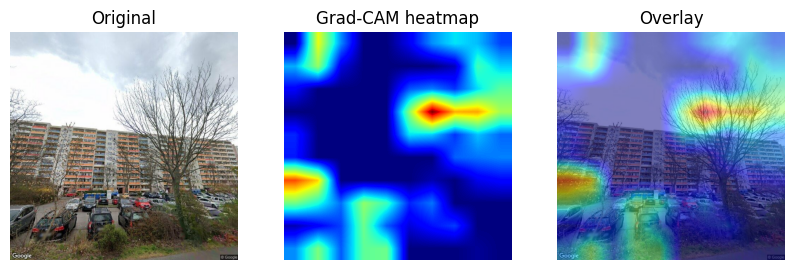

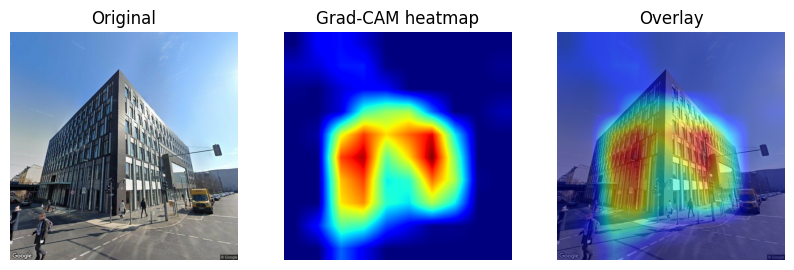

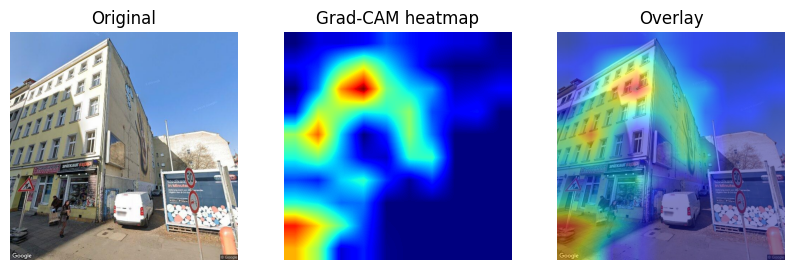

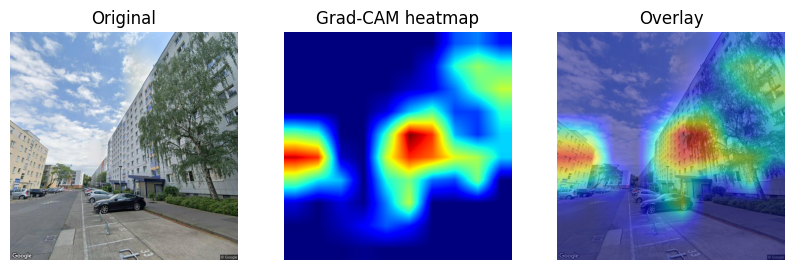

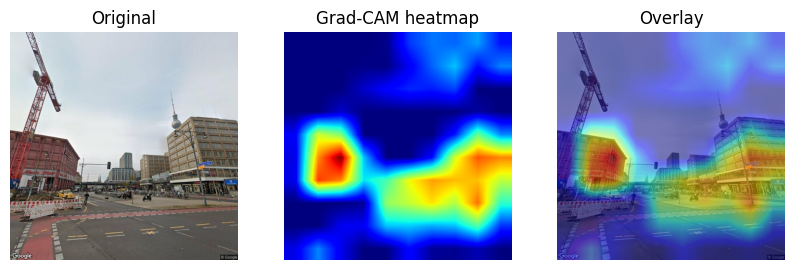

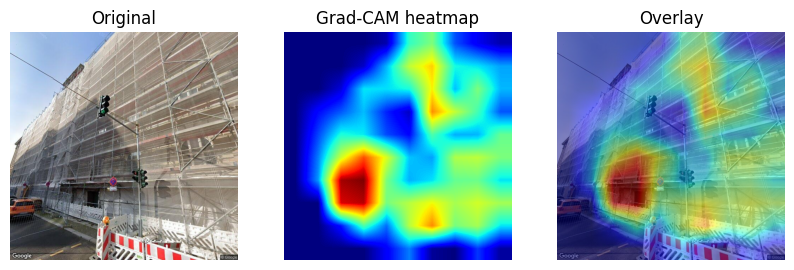

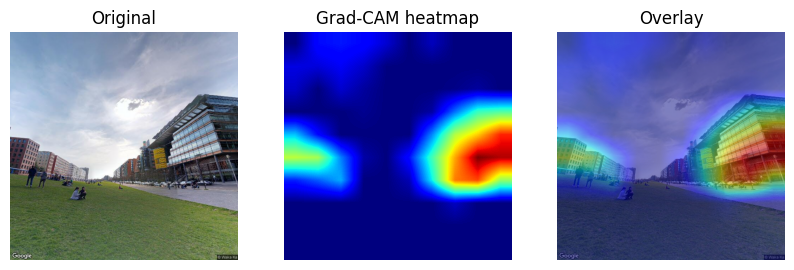

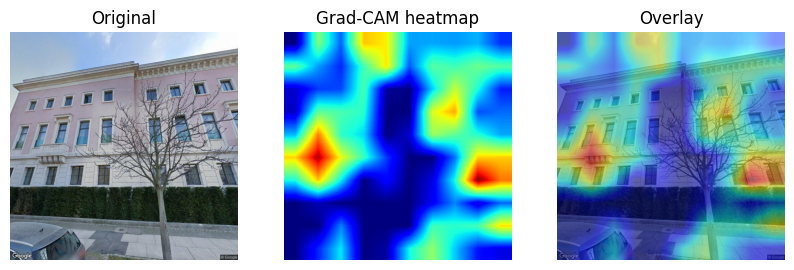

In [ ]:
## Iteration cell
for ii in range(len(images_Gropiusstadt)):
    activations = {}
    gradients = {}
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    cam = CAM(X_Gropiusstadt[ii])
    Plot(cam, images_Gropiusstadt[ii], 'Gropiusstadt', ii)

    fwd_handle.remove()
    bwd_handle.remove()

for ii in range(len(images_Marzahn)):
    activations = {}
    gradients = {}
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    cam = CAM(X_Marzahn[ii])
    Plot(cam, images_Marzahn[ii], 'Marzahn', ii)

    fwd_handle.remove()
    bwd_handle.remove()

for ii in range(len(images_Mitte)):
    activations = {}
    gradients = {}
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    cam = CAM(X_Mitte[ii])
    Plot(cam, images_Mitte[ii], 'Mitte', ii)

    fwd_handle.remove()
    bwd_handle.remove()

for ii in range(len(images_Tiergarten)):
    activations = {}
    gradients = {}
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    cam = CAM(X_Tiergarten[ii])
    Plot(cam, images_Tiergarten[ii], 'Tiergarten', ii)

    fwd_handle.remove()
    bwd_handle.remove()